# **Assignment 7: Attention-based Neural Machine Translation**
By Geetha Doddapaneni Gopinath (229498), Sri Chandana Hudukula Ram Kumar (231616),Joy Rakshit(231681)



In [6]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pathlib
from google.colab import drive
import os 

In [7]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/')
path_to_file = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/deu-eng/deu.txt")

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Classes and/or  Functions Needed for the Assignment 

## Data Preprocessing 

In [9]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t')[:-1] for line in lines]

  inp = [inp for targ, inp in pairs]
  targ = [targ for targ, inp in pairs]

  return targ, inp

def data_replace(data):
  for i in range(len(data)):
    temp = list(data[i])
    for j in range(len(temp)):
      if temp[j]=='ß':
        temp[j] = 'ss'
    data[i]="".join(temp)
  return data

#Text Preprocessing function (Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents)
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

## Shape Checker

In [10]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)
    print(rank)
    print(shape)
    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## Encoder

The encoder:

- Takes a list of token IDs (from input_text_processor).
- Looks up an embedding vector for each token (Using a layers.Embedding).
- Processes the embeddings into a new sequence (Using a layers.GRU).
- Returns:
  - The processed sequence. This will be passed to the attention head.
  - The internal state. This will be used to initialize the decoder

In [11]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)


    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state


## Attention

In [12]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights


## Decoder

In [13]:
import typing
from typing import Any, Tuple

class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [14]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

  def call(self,inputs: DecoderInput,state=None) -> Tuple[DecoderOutput, tf.Tensor]:
        shape_checker = ShapeChecker()
        shape_checker(inputs.new_tokens, ('batch', 't'))
        shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
        shape_checker(inputs.mask, ('batch', 's'))

        if state is not None:
            shape_checker(state, ('batch', 'dec_units'))

        # Step 1. Lookup the embeddings
        vectors = self.embedding(inputs.new_tokens)
        shape_checker(vectors, ('batch', 't', 'embedding_dim'))

        # Step 2. Process one step with the RNN
        rnn_output, state = self.gru(vectors, initial_state=state)

        shape_checker(rnn_output, ('batch', 't', 'dec_units'))
        shape_checker(state, ('batch', 'dec_units'))

        # Step 3. Use the RNN output as the query for the attention over the
        # encoder output.
        context_vector, attention_weights = self.attention(
            query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
        shape_checker(context_vector, ('batch', 't', 'dec_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))

        # Step 4. Eqn. (3): Join the context_vector and rnn_output
        #     [ct; ht] shape: (batch t, value_units + query_units)
        context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

        # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
        attention_vector = self.Wc(context_and_rnn_output)
        shape_checker(attention_vector, ('batch', 't', 'dec_units'))

        # Step 5. Generate logit predictions:
        logits = self.fc(attention_vector)
        shape_checker(logits, ('batch', 't', 'output_vocab_size'))

        return DecoderOutput(logits, attention_weights), state


## Loss

In [15]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

## Training 

In [16]:
class TrainTranslator(tf.keras.Model):
    def __init__(self, embedding_dim, units,input_text_processor,output_text_processor,use_tf_function=True):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(input_text_processor.vocabulary_size(),embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(),embedding_dim, units)
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function
        self.shape_checker = ShapeChecker()

    def train_step(self, inputs):
        self.shape_checker = ShapeChecker()
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)

    def _preprocess(self, input_text, target_text):
        self.shape_checker(input_text, ('batch',))
        self.shape_checker(target_text, ('batch',))

        # Convert the text to token IDs
        input_tokens = self.input_text_processor(input_text)
        target_tokens = self.output_text_processor(target_text)
        self.shape_checker(input_tokens, ('batch', 's'))
        self.shape_checker(target_tokens, ('batch', 't'))

        # Convert IDs to masks.
        input_mask = input_tokens != 0
        self.shape_checker(input_mask, ('batch', 's'))

        target_mask = target_tokens != 0
        self.shape_checker(target_mask, ('batch', 't'))

        return input_tokens, input_mask, target_tokens, target_mask

    def _train_step(self, inputs):
        input_text, target_text = inputs

        (input_tokens, input_mask,target_tokens, target_mask) = self._preprocess(input_text, target_text)

        max_target_length = tf.shape(target_tokens)[1]

        with tf.GradientTape() as tape:
            # Encode the input
            enc_output, enc_state = self.encoder(input_tokens)
            self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
            self.shape_checker(enc_state, ('batch', 'enc_units'))

            # Initialize the decoder's state to the encoder's final state.
            # This only works if the encoder and decoder have the same number of
            # units.
            dec_state = enc_state
            loss = tf.constant(0.0)

            for t in tf.range(max_target_length - 1):
                # Pass in two tokens from the target sequence:
                # 1. The current input to the decoder.
                # 2. The target for the decoder's next prediction.
                new_tokens = target_tokens[:, t:t + 2]
                step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                                     enc_output, dec_state)
                loss = loss + step_loss

            # Average the loss over all non padding tokens.
            average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

        # Apply an optimization step
        variables = self.trainable_variables
        gradients = tape.gradient(average_loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))

        # Return a dict mapping metric names to current value
        return {'batch_loss': average_loss}

    def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
        input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

        # Run the decoder one step.
        decoder_input = DecoderInput(new_tokens=input_token,
                                     enc_output=enc_output,
                                     mask=input_mask)
        dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
        self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
        self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
        self.shape_checker(dec_state, ('batch', 'dec_units'))

        # `self.loss` returns the total for non-padded tokens
        y = target_token
        y_pred = dec_result.logits
        step_loss = self.loss(y, y_pred)

        return step_loss, dec_state

    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
    def _tf_train_step(self, inputs):
      return self._train_step(inputs)


## Batch Logs

In [17]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

## Translator

In [27]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

  def tokens_to_text(self, result_tokens):
    shape_checker = ShapeChecker()
    shape_checker(result_tokens, ('batch', 't'))
    result_text_tokens = self.output_token_string_from_index(result_tokens)
    shape_checker(result_text_tokens, ('batch', 't'))

    result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
    shape_checker(result_text, ('batch'))

    result_text = tf.strings.strip(result_text)
    shape_checker(result_text, ('batch',))
    return result_text

  def sample(self, logits, temperature):
    shape_checker = ShapeChecker()
    # 't' is usually 1 here.
    shape_checker(logits, ('batch', 't', 'vocab'))
    shape_checker(self.token_mask, ('vocab',))

    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
    shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

    # Set the logits for all masked tokens to -inf, so they are never chosen.
    logits = tf.where(self.token_mask, -np.inf, logits)

    if temperature == 0.0:
      new_tokens = tf.argmax(logits, axis=-1)
    else: 
      logits = tf.squeeze(logits, axis=1)
      new_tokens = tf.random.categorical(logits/temperature,
                                          num_samples=1)

    shape_checker(new_tokens, ('batch', 't'))

    return new_tokens
  
  def translate(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
    batch_size = tf.shape(input_text)[0]
    input_tokens = self.input_text_processor(input_text)
    enc_output, enc_state = self.encoder(input_tokens)

    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)

    result_tokens = []
    attention = []
    done = tf.zeros([batch_size, 1], dtype=tf.bool)

    for _ in range(max_length):
      dec_input = DecoderInput(new_tokens=new_tokens,
                              enc_output=enc_output,
                              mask=(input_tokens!=0))

      dec_result, dec_state = self.decoder(dec_input, state=dec_state)

      attention.append(dec_result.attention_weights)

      new_tokens = self.sample(dec_result.logits, temperature)

      # If a sequence produces an `end_token`, set it `done`
      done = done | (new_tokens == self.end_token)
      # Once a sequence is done it only produces 0-padding.
      new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

      # Collect the generated tokens
      result_tokens.append(new_tokens)

      if tf.executing_eagerly() and tf.reduce_all(done):
        break

    # Convert the list of generates token ids to a list of strings.
    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text = self.tokens_to_text(result_tokens)

    if return_attention:
      attention_stack = tf.concat(attention, axis=1)
      return {'text': result_text, 'attention': attention_stack}
    else:
      return {'text': result_text}

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def tf_translate(self, input_text):
    return self.translate(input_text)

# Data and Training 


### Download and prepare Dataset 

In [19]:
targ, inp = load_data(path_to_file) #Note : Target-> English Translation  Input -> German Input 
inp = data_replace(inp) #Replacing 'ß' by 'ss'

In [20]:
#Hyper Parameters 
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64
max_vocab_size = 5000
embedding_dim = 256
units = 1024

In [21]:
#Create a tf.data dataset
dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [22]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'Tom weiss das jetzt.' b'Ich kann in 30 Minuten dort sein.'
 b'Verrichte einfach deine Arbeit!'
 b'\xe2\x80\x9eHast du schon einmal original ungarisches Gulasch gegessen?\xe2\x80\x9c\xc2\xa0\xe2\x80\x93 \xe2\x80\x9eNein, aber ich w\xc3\xbcrde wirklich gerne mal.\xe2\x80\x9c'
 b'Ich m\xc3\xb6chte dir gerne dieses Bild von Tom zeigen.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Tom knows that now.' b'I can be there in 30 minutes.'
 b'Just do your job.'
 b'"Have you ever had genuine Hungarian goulash?" "No, but I\'d really like to."'
 b"I'd like to show this picture of Tom to you."], shape=(5,), dtype=string)


### Text preprocessing

- Standardization using the function 'tf_lower_and_split_punct', where Unicode normalization will be the first step
- Text Vectorisation - wrapped up in a tf.keras.layers.TextVectorization layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.


In [23]:
#Text Vectorization
#Returned tokens are zero padded.
input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)
input_text_processor.adapt(inp)
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)
output_text_processor.adapt(targ)

In [24]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=True)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)
batch_loss = BatchLogs('batch_loss')
train_translator.fit(dataset, epochs=5,
                     callbacks=[batch_loss])

Epoch 1/5
3880/3880 [==============================] - 1944s 498ms/step - batch_loss: 1.6297
Epoch 2/5
3880/3880 [==============================] - 1932s 498ms/step - batch_loss: 0.9116
Epoch 3/5
3880/3880 [==============================] - 1912s 493ms/step - batch_loss: 0.7225
Epoch 4/5
3880/3880 [==============================] - 1925s 496ms/step - batch_loss: 0.5865
Epoch 5/5
3880/3880 [==============================] - 1925s 496ms/step - batch_loss: 0.4813


In [28]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

tf.saved_model.save(translator, 'translator',
                    signatures={'serving_default': translator.tf_translate})

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


In [31]:
reloaded = tf.saved_model.load('translator')
three_input_text = tf.constant([
    'Ich reise nach Berlin.',
    'Hallo!',
    'Sie sind da',
])
result = reloaded.tf_translate(three_input_text)
for tr in result['text']:
  print(tr.numpy().decode())


im going hunting .
hi , its fine .
theyre busy .


In [32]:
reloaded = tf.saved_model.load('translator')
three_input_text = tf.constant([
    'Ich reise nach Berlin.',
    'Hallo!',
    'Sie sind da',
])
result = reloaded.tf_translate(three_input_text)
for tr in result['text']:
  print(tr.numpy().decode())

i am traveling by air .
hi .
they are in touch heaven .


Text(0, 0.5, 'CE/token')

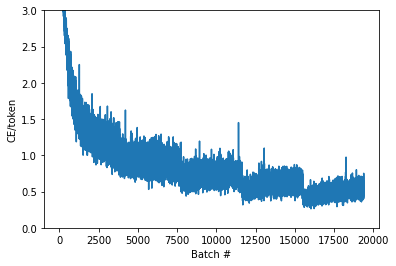

In [33]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

#### Questions

1. Which parts of the sentence are used as a token? Each character, each word, or are some words split up?

  Each word/punctuation(example: verb as well as verb+tense) are taken as tokens. Please see the output of the cells below for an illustration.

2. Do the same tokens in different language have the same ID? e.g. Would the same token index map to the German word die and to the English word die?
  
  In the illustration below, we can see that even though the words 'zoo' and 'bitter' have the same meaning in both language, we can see that they have different token ids, hence two words even if they have the same spelling, there is no guarantee that they will have the same ID. It would be just a coincidence if this happens.

3. What is the relation between the encoder output and the encoder hidden state which is used to initialize the decoder hidden state (for the architecture used in the tutorial)?

  - Encoder output is the tensor for all timesteps, which has shape [batch, time, units]
  - Encoder state is the output tensor for the last timestep, which has shape [batch, units]
  - Encoder state or the internal state is used to initialize the decoder

4.  Is the decoder attending to all previous positions, including the previous decoder predictions?
  
  Decoder at timestep 't' uses the state at 't-1' to attend to the entire encoder output to calculate the attention weights(followed by context vector and attention vector)

5. Does the encoder output change in different decoding steps?
   
   No, encoder processes the whole sequence and generates an output, which remains constant and serves as value to the decoder. 

6. Does the context vector change in different decoding steps?

   Yes, attention weights are calculated at every timestep of the decoder based on the previous timestep of the decoder, and using the updated attention weight, decoder attends to the encoder output to generate the context vector. Hence, cotext vector changes at every decoding step.

7. The decoder uses teacher forcing. Does this mean the time steps can be computed in parallel?

  In this implementation, the  context vector is generated based on previous state of the decoder, hence even though we are using teacher forcing (giving the previous token as input to predict the current token), we cannot parallelise the decoder 

8. Why is a mask applied to the loss function?
   
   Due to rectagular implementation .i.e, in a batch the records are padded to the length of the longest sequence, the mask is applied to ensure we are considering the loss pertaining only to the sequence rather than padding. 

9. When translating the same sentence multiple times, do you get the same result? Why (not)? If not, what changes need to be made to get the same result each time?


In [119]:
print('------------------\n  For Question 1 \n------------------')
input_text_processor.adapt(example_input_batch)
output_text_processor.adapt(example_target_batch)
print('Vocabulary extracted from Input sequences: \n{}'.format(input_text_processor.get_vocabulary()[:20]))
print('Vocabulary extracted from Target sequences: \n{}'.format(output_text_processor.get_vocabulary()[:20]))
print('------------------\n  For Question 2 \n------------------')
example_input_tokens = input_text_processor(example_input_batch)
print('\nExample 1: \nInput Token IDs:\n',example_input_tokens[0])
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_input_tokens[0].numpy()]
print('Corresponding Text:\n {}'.format(' '.join(tokens)))

example_target_tokens = output_text_processor(example_target_batch)
print('Target Token IDs:\n',example_target_tokens[0])
target_vocab = np.array(output_text_processor.get_vocabulary())
tokens = target_vocab[example_target_tokens[0].numpy()]
print('Corresponding Text:\n {} \n'.format(' '.join(tokens)))

print('\nExample 2: \nInput Token IDs:\n',example_input_tokens[1])
tokens = input_vocab[example_input_tokens[1].numpy()]
print('Corresponding Text:\n {}'.format(' '.join(tokens)))
print('Target Token IDs:\n',example_target_tokens[1])
tokens = target_vocab[example_target_tokens[1].numpy()]
print('Corresponding Text:\n {} \n'.format(' '.join(tokens)))



------------------
  For Question 1 
------------------
Vocabulary extracted from Input sequences: 
['', '[UNK]', '[START]', '[END]', '.', 'tom', 'ich', 'das', ',', 'ist', '?', 'zu', 'nicht', 'in', 'hat', 'wir', 'du', 'die', 'den', 'sie']
Vocabulary extracted from Target sequences: 
['', '[UNK]', '[START]', '[END]', '.', 'the', 'tom', 'to', 'i', 'a', 'this', 'my', '?', 'you', 'in', 'have', 'that', 'is', 'your', 'we']
------------------
  For Question 2 
------------------

Example 1: 
Input Token IDs:
 tf.Tensor([  2   6 250  26  60   4   3   0   0   0   0   0   0   0   0   0   0   0], shape=(18,), dtype=int64)
Corresponding Text:
 [START] ich arbeite im zoo . [END]           
Target Token IDs:
 tf.Tensor([  2   8  67 226   5  64   4   3   0   0   0   0   0   0   0], shape=(15,), dtype=int64)
Corresponding Text:
 [START] i work at the zoo . [END]        


Example 2: 
Input Token IDs:
 tf.Tensor([  2 227  96   9  11 235   4   3   0   0   0   0   0   0   0   0   0   0], shape=(18,), dty